
참고링크
-  https://lsjsj92.tistory.com/568
- https://romg2.github.io/mlguide/02_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-%EC%99%84%EB%B2%BD%EA%B0%80%EC%9D%B4%EB%93%9C-09.-%EC%B6%94%EC%B2%9C%EC%8B%9C%EC%8A%A4%ED%85%9C-%EC%B5%9C%EA%B7%BC%EC%A0%91-%EC%9D%B4%EC%9B%83/
- https://dawnpast12.tistory.com/entry/220209TIL


## 환경설정

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/BOAZ/분석adv

/content/drive/MyDrive/BOAZ/분석adv


In [3]:
pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 1.3 MB/s 
     |████████████████████████████████| 453 kB 55.5 MB/s 


In [4]:
# 데이터 조작 관련
import pandas as pd
import numpy as np
import seaborn as sns
import re
import io

# 한국어 nlp
from konlpy.tag import *   # 모든 형태소분석기 import 하기
#1. hannanum = Hannanum()
#2. kkma = Kkma()
#3. komoran = Komoran()
#4. okt = Okt()

okt = Okt()

### 위 4개중 원하는 형태소분석기를 사용하면 됨 --> okt추천

# 영어 nlp 관련
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize

# 시각화 관련
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image

# 기타
from tqdm import tqdm_notebook, tqdm   # for문 진행상황 눈으로 확인 (loading bar)
import datetime

In [5]:
from sklearn.metrics.pairwise import cosine_similarity

## 파일 불러오기 & 전처리

In [6]:
df1 = pd.read_csv('무신사_바지_하의_크롤링_1차결과.csv',encoding = 'cp949')
df1.head()

,상품명,구매사이즈,성별,키,몸무게,착용사이즈,착용두께감,리뷰
0,슬림 크롭 12.5oz 트윌 크림진,32,남성,173cm,72kg,보통이에요,보통이에요,엘라 포함되지않았는데 크게 불편하지않고 살빼는 중인데 조금만 빼면 딱 맞을것 같네요.
1,슬림 크롭 12.5oz 트윌 크림진,28,남성,167cm,60kg,보통이에요,보통이에요,핏이나 색감 두께감 전반적으로 좋습니다\n색상은 밖에서 보면 흰색에 가까워요
2,슬림 크롭 12.5oz 트윌 크림진,32,남성,177cm,75kg,보통이에요,보통이에요,재작년인가부터 깡형 등 유튜버들로 인해 입소문났던 바지라 한번쯤 입어보고 싶단 생각...
3,슬림 크롭 12.5oz 트윌 크림진,32,NaN,NaN,NaN,보통이에요,보통이에요,핏 좋고 색감 좋고 예쁩니다. 신축성은 거의 없고 원단은 좀 두꺼워요.
4,슬림 크롭 12.5oz 트윌 크림진,28,NaN,NaN,NaN,보통이에요,두꺼워요,핏 좋구요\n스판덱스가 없어서 좀 빳빳한게 아쉽네여\n옷 색감 이쁨 ㅎㅎ


In [7]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   상품명     100 non-null    object
 1   구매사이즈   100 non-null    object
 2   성별      86 non-null     object
 3   키       86 non-null     object
 4   몸무게     86 non-null     object
 5   착용사이즈   100 non-null    object
 6   착용두께감   100 non-null    object
 7   리뷰      100 non-null    object
dtypes: object(8)
memory usage: 6.4+ KB


In [8]:
#null 행 제거
df1 = df1.dropna(axis=0)
df1.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 86 entries, 0 to 99
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   상품명     86 non-null     object
 1   구매사이즈   86 non-null     object
 2   성별      86 non-null     object
 3   키       86 non-null     object
 4   몸무게     86 non-null     object
 5   착용사이즈   86 non-null     object
 6   착용두께감   86 non-null     object
 7   리뷰      86 non-null     object
dtypes: object(8)
memory usage: 6.0+ KB


In [9]:
#kg과 cm제거하고 숫자만 남겨놓음_피벗을 위함
df1["키"] = df1["키"].replace('cm','',regex = True)
df1["몸무게"] = df1["몸무게"].replace('kg','',regex = True)
##df1["몸무게"] = df["몸무게"].str[:3]

In [10]:
#"슬림 크롭 12.5oz 트윌 크림진" 만 사용, 다른 제품들은 사이즈 문자형이고 일단 제품안에서의 사이즈 추천을 위함
df1 = df1[df1["상품명"] == "슬림 크롭 12.5oz 트윌 크림진"]

In [11]:
#피벗에 사용할 칼럼 숫자형으로 변경_기존엔 문자형이었음.
df1["키"] = pd.to_numeric(df1["키"])
df1["몸무게"] = pd.to_numeric(df1["몸무게"])
df1["구매사이즈"] = pd.to_numeric(df1["구매사이즈"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [12]:
df_sample = df1

In [13]:
#최종 데이터셋 df_sample
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48 entries, 0 to 49
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   상품명     48 non-null     object
 1   구매사이즈   48 non-null     int64 
 2   성별      48 non-null     object
 3   키       48 non-null     int64 
 4   몸무게     48 non-null     int64 
 5   착용사이즈   48 non-null     object
 6   착용두께감   48 non-null     object
 7   리뷰      48 non-null     object
dtypes: int64(3), object(5)
memory usage: 3.4+ KB


In [14]:
df_sample.head()

,상품명,구매사이즈,성별,키,몸무게,착용사이즈,착용두께감,리뷰
0,슬림 크롭 12.5oz 트윌 크림진,32,남성,173,72,보통이에요,보통이에요,엘라 포함되지않았는데 크게 불편하지않고 살빼는 중인데 조금만 빼면 딱 맞을것 같네요.
1,슬림 크롭 12.5oz 트윌 크림진,28,남성,167,60,보통이에요,보통이에요,핏이나 색감 두께감 전반적으로 좋습니다\n색상은 밖에서 보면 흰색에 가까워요
2,슬림 크롭 12.5oz 트윌 크림진,32,남성,177,75,보통이에요,보통이에요,재작년인가부터 깡형 등 유튜버들로 인해 입소문났던 바지라 한번쯤 입어보고 싶단 생각...
5,슬림 크롭 12.5oz 트윌 크림진,30,남성,173,63,보통이에요,보통이에요,크림색보다는 흰색에 가깝습니다. 구매하실 때 참고하세요
6,슬림 크롭 12.5oz 트윌 크림진,28,남성,165,55,보통이에요,보통이에요,너무 하얗지 않아서 부담스럽지않고 마르신분들도 예쁘게 입을수 있어요


## 피벗

### pivot1 -- index : 몸무게 

In [ ]:
#구매사이즈, 키, 몸무게 사용
pivot1= df_sample.pivot_table("구매사이즈", index = "몸무게", columns = "키")

In [ ]:
pivot1.head()

키,162,163,165,167,168,170,171,172,173,174,175,176,177,178,179,180,181,183,184,185
몸무게,,,,,,,,,,,,,,,,,,,,
44,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52,NaN,28.0,NaN,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,NaN,NaN,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#null값 0으로
pivot1.fillna(0,inplace = True)
pivot1.head(3)

키,162,163,165,167,168,170,171,172,173,174,175,176,177,178,179,180,181,183,184,185
몸무게,,,,,,,,,,,,,,,,,,,,
44,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52,0.0,28.0,0.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### cosine similarity

In [ ]:
weight_based = cosine_similarity(pivot1)
weight_based

array([[1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.57735027, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 1.        , 0.        , 0.        ,
        0.34115913, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.

In [ ]:
weight_based = pd.DataFrame(data = weight_based, index = pivot1.index, columns = pivot1.index)
weight_based.head()

몸무게,44,49,52,55,59,60,61,62,63,64,...,70,72,73,74,75,76,78,85,86,90
몸무게,,,,,,,,,,,,,,,,,,,,,
44,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49,0.0,1.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.000000,0.0,...,0.0,0.57735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52,0.0,0.0,1.0,0.0,0.0,0.341159,0.0,0.0,0.000000,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
55,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.441176,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
def get_weight_based(몸무게):
  return weight_based[몸무게].sort_values(ascending = False)[:6]

In [ ]:
#구매한 사이즈로 유사도를 구했으므로 입력한 몸무게에 따라 비슷한 사이즈를 구매한 몸무게를 알 수 있음
# ->비슷한 사이즈를 구매한 몸무게 순위
#몸무게가 60인 그룹과 비슷한 사이즈를 구매한 그룹 1위는 몸무게 62인 그룹이고 그 다음은 69인 그룹이다.
get_weight_based(60)

몸무게
60    1.000000
62    0.482472
69    0.482472
75    0.365528
52    0.341159
67    0.317878
Name: 60, dtype: float64

### pivot2 -- index : 구매사이즈

In [ ]:
pivot2= df_sample.pivot_table("몸무게", index = "구매사이즈", columns = "키")
pivot2.fillna(0,inplace = True)
pivot2.head()

키,162,163,165,167,168,170,171,172,173,174,175,176,177,178,179,180,181,183,184,185
구매사이즈,,,,,,,,,,,,,,,,,,,,
28,44.0,52.0,55.0,56.0,0.0,64.5,64.0,0.0,67.0,59.0,55.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30,0.0,0.0,63.0,0.0,70.0,62.0,67.0,61.5,65.0,0.0,0.0,0.000000,63.666667,60.0,0.0,0.0,0.0,0.0,0.0,0.0
32,0.0,0.0,0.0,0.0,0.0,68.0,0.0,69.5,72.5,0.0,72.0,0.000000,69.500000,75.0,63.0,0.0,0.0,0.0,0.0,0.0
34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74.666667,0.000000,0.0,0.0,0.0,0.0,0.0,73.0,70.0
36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,87.5,86.0,90.0,0.0,0.0


### cosine similarity

In [ ]:
size_based = cosine_similarity(pivot2)
size_based

array([[1.        , 0.51253624, 0.41113537, 0.        , 0.        ],
       [0.51253624, 1.        , 0.6588957 , 0.        , 0.        ],
       [0.41113537, 0.6588957 , 1.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 1.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 1.        ]])

In [ ]:
size_based = pd.DataFrame(data = size_based, index = pivot2.index, columns = pivot2.index)
size_based.head()

구매사이즈,28,30,32,34,36
구매사이즈,,,,,
28,1.000000,0.512536,0.411135,0.0,0.0
30,0.512536,1.000000,0.658896,0.0,0.0
32,0.411135,0.658896,1.000000,0.0,0.0
34,0.000000,0.000000,0.000000,1.0,0.0
36,0.000000,0.000000,0.000000,0.0,1.0


In [ ]:
def get_size_based(구매사이즈):
  return size_based[구매사이즈].sort_values(ascending = False)[:6]

In [ ]:
#몸무게로 유사도를 구했으므로 입력한 사이즈에 따라 비슷한 몸무게인 사이즈를 알 수 있음
#->비슷한 몸무게인 사이즈 순위
# 32를 구매한 몸무게 그룹은 그다음으로 30을 구매했으며 그다음은 28이다.
get_size_based(32)

구매사이즈
32    1.000000
30    0.658896
28    0.411135
34    0.000000
36    0.000000
Name: 32, dtype: float64

### pivot3 -- index : 키

In [ ]:
pivot3= df_sample.pivot_table("구매사이즈", index = "키", columns = "몸무게")
pivot3.fillna(0,inplace = True)
pivot3.head()

몸무게,44,49,52,55,59,60,61,62,63,64,...,70,72,73,74,75,76,78,85,86,90
키,,,,,,,,,,,,,,,,,,,,,
162,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
163,0.0,0.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
165,0.0,0.0,0.0,28.0,0.0,0.0,0.0,0.0,30.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
167,0.0,0.0,28.0,0.0,0.0,28.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
height_based = cosine_similarity(pivot3)
height_based

array([[1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.70710678, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.35355252, 0.29486986, 0.        ,
        0.        , 0.        , 0.35355252, 0.        , 0.73105527,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.70710678, 0.        , 1.        , 0.        ,
        0.29462261, 0.        , 0.34197056, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0

In [ ]:
height_based = pd.DataFrame(data = height_based, index = pivot3.index, columns = pivot3.index)
height_based.head()

키,162,163,165,167,168,170,171,172,173,174,175,176,177,178,179,180,181,183,184,185
키,,,,,,,,,,,,,,,,,,,,
162,1.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
163,0.0,1.000000,0.0,0.707107,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
165,0.0,0.000000,1.0,0.000000,0.0,0.000000,0.0,0.353553,0.29487,0.0,0.0,0.0,0.353553,0.000000,0.731055,0.0,0.0,0.0,0.0,0.0
167,0.0,0.707107,0.0,1.000000,0.0,0.294623,0.0,0.341971,0.00000,0.0,0.0,0.0,0.000000,0.483619,0.000000,0.0,0.0,0.0,0.0,0.0
168,0.0,0.000000,0.0,0.000000,1.0,0.476182,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0


In [ ]:
def get_height_based(키):
  return height_based[키].sort_values(ascending = False)[:6]

In [ ]:
#구매한 사이즈로 유사도를 구했으므로 입력한 키에 따라 비슷한 사이즈를 구매한 키를 알 수 있음
# ->비슷한 사이즈를 구매한 키 순위
#키가 175인 그룹과 비슷한 사이즈를 구매한 그룹 1위는 키가 172인 그룹이고 그 다음은 173인 그룹이다.
get_height_based(175)

키
175    1.000000
172    0.324239
173    0.270422
176    0.000000
184    0.000000
183    0.000000
Name: 175, dtype: float64

## 클러스터링

### 환경설정


In [15]:
# data
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore") 

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# model
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import dendrogram, ward
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import MeanShift, estimate_bandwidth

# grid search
from sklearn.model_selection import GridSearchCV

# evaluation
from sklearn.metrics.cluster import silhouette_score
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import *

### 전처리

In [16]:
df_cluster = df_sample.drop(["상품명","착용사이즈","착용두께감","리뷰","성별"],axis = 1)
df_cluster.head()

,구매사이즈,키,몸무게
0,32,173,72
1,28,167,60
2,32,177,75
5,30,173,63
6,28,165,55


## clustering

In [17]:
scaler = MinMaxScaler()
df_cluster_new = scaler.fit_transform(df_cluster)
df_cluster_new = pd.DataFrame(df_cluster_new)
df_cluster_new.columns = df_cluster.columns

Text(0, 0.5, 'Inertia')

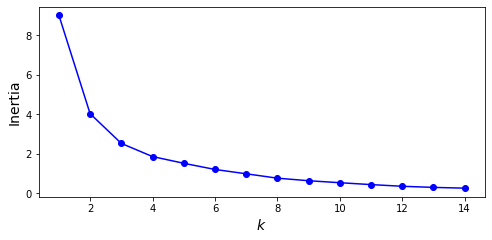

In [18]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(df_cluster_new) for k in range(1, 15)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 15), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)

In [20]:
k = 4

# 그룹 수, random_state 설정
model = KMeans(n_clusters = k, random_state = 42)

# 클러스터링 결과 각 데이터가 몇 번째 그룹에 속하는지 저장
df_cluster['cluster'] = model.fit_predict(df_cluster_new)
df_cluster_new['cluster'] = model.fit_predict(df_cluster_new)
df_cluster.head()

,구매사이즈,키,몸무게,cluster
0,32,173,72,1
1,28,167,60,0
2,32,177,75,1
5,30,173,63,0
6,28,165,55,2


In [21]:
df_cluster.to_csv('musinsa_cluster_sample.csv')

# 비고

In [ ]:
#년도와 월별로 그룹화
df.groupby(['시설명','year1','month1'])['전년현지인총합','전년외지인총합','전년외국인총합',
                                     '금년현지인총합','금년외지인총합','금년외국인총합',
                                     '금년현지인증감수','금년외지인증감수','금년외국인증감수',
                                     '금년현지인증감율','금년외지인증감율','금년외국인증감율'].mean()